## Data Scientist Assignment
by **Aini Nur Zahiyah Maulani**

### ETL + EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import statsmodels.formula.api as smf

In [3]:
sales = pd.read_excel("datasets/2020 - 2022 US Sales.xlsx")
holidays = pd.read_excel("datasets/2020 - 2022 US Holidays.xlsx")

In [4]:
display(sales.head())
display(holidays.head())

,Order Date,Subject Category,Sales Amount,Sales Quantity
0,2020-01-01,Science & Technology,30734.01,581
1,2020-01-02,Science & Technology,50991.12,1015
2,2020-01-03,Science & Technology,50222.00,999
3,2020-01-04,Science & Technology,33865.67,661
4,2020-01-05,Science & Technology,38874.10,748


,Date,Holiday
0,2020-01-01,New Year's Day
1,2020-01-20,Martin Luther King Jr. Day
2,2020-02-17,Washington's Birthday / Presidents Day
3,2020-05-25,Memorial Day
4,2020-07-03,Independence Day (observed)


In [5]:
holidays.head()

,Date,Holiday
0,2020-01-01,New Year's Day
1,2020-01-20,Martin Luther King Jr. Day
2,2020-02-17,Washington's Birthday / Presidents Day
3,2020-05-25,Memorial Day
4,2020-07-03,Independence Day (observed)


In [6]:
sales["Order Date"] = pd.to_datetime(sales["Order Date"])
holidays["Date"] = pd.to_datetime(holidays["Date"])

In [7]:
sales = sales.rename(columns=
    {
        "Order Date":"date",
        "Subject Category":"category",
        "Sales Amount":"revenue",
        "Sales Quantity":"qty"
    }
)

In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2192 non-null   datetime64[ns]
 1   category  2192 non-null   object        
 2   revenue   2192 non-null   float64       
 3   qty       2192 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 68.6+ KB


In [9]:
cats = list(sales["category"].unique())
targets = ["revenue", "qty"] # cols for target/y

In [ ]:
# sanity checks
print(f"date range: {sales.date.min()} - {sales.date.max()}")
print(f"categories: {sales.category.unique()}")
print(f"neg revenue: {(sales.revenue < 0).sum()}")
print(f"neg qty: {(sales.qty < 0).sum()}")

date range: 2020-01-01 00:00:00 - 2022-12-31 00:00:00
categories: ['Science & Technology' 'Medical']
neg revenue: 0
neg qty: 0


In [11]:
# Check if there are skipped dates
daily = (sales.groupby([pd.Grouper(freq="D", key="date"), "category"], as_index=False)).agg({"revenue":"sum", "qty":"sum"})
all_dates = pd.date_range(daily["date"].min(), daily["date"].max(), freq="D")

skipped_dates_by_cat = {
    cat: all_dates.difference(daily.loc[daily["category"] == cat, "date"]) for cat in daily["category"].unique()
}

for cat, skip in skipped_dates_by_cat.items():
    print(f"{cat} skipped dates: {len(skip)}")

Medical skipped dates: 0
Science & Technology skipped dates: 0


In [12]:
df = daily.copy()
panel = (pd.MultiIndex.from_product([all_dates, cats], names=["date","category"])
         .to_frame(index=False)
         .merge(df, on=["date","category"], how="left"))

panel[["revenue","qty"]] = panel[["revenue","qty"]].fillna(0.0)
df = panel

In [13]:
df.head()

,date,category,revenue,qty
0,2020-01-01,Science & Technology,30734.01,581
1,2020-01-01,Medical,37920.81,691
2,2020-01-02,Science & Technology,50991.12,1015
3,2020-01-02,Medical,72643.01,1425
4,2020-01-03,Science & Technology,50222.00,999


In [14]:
for cat in cats:
    sub = df[df["category"] == cat]
    print(f"\n{cat}")
    print(sub[["revenue", "qty"]].describe(percentiles=[.5, .9, .95, .99]))


Science & Technology
             revenue          qty
count    1096.000000  1096.000000
mean    27129.471962   542.536496
std     19911.217507   385.157280
min      4653.760000    86.000000
50%     21661.100000   449.000000
90%     50565.615000   975.500000
95%     69035.992500  1354.750000
99%    103281.242500  2000.500000
max    159839.590000  3171.000000

Medical
             revenue          qty
count    1096.000000  1096.000000
mean    36031.692901   590.684307
std     21958.442178   390.576044
min      6964.340000    97.000000
50%     30194.415000   502.000000
90%     62807.115000  1053.000000
95%     76684.817500  1294.250000
99%    110216.234000  1964.950000
max    182034.110000  2919.000000


In [15]:
hol_dates = set(holidays["Date"])
hol_dates = pd.to_datetime(holidays["Date"]).dt.normalize()
df["date"] = pd.to_datetime(df["date"]).dt.normalize()
hol_set = set(hol_dates)

df["is_holiday"] = df["date"].isin(hol_dates).astype(int)
df["is_holiday_tmr"] = (df["date"] + pd.Timedelta(days=1)).isin(hol_dates).astype(int) # is tomorrow holiday?
df["is_holiday_ytd"] = (df["date"] - pd.Timedelta(days=1)).isin(hol_dates).astype(int) # is yesterday holiday?

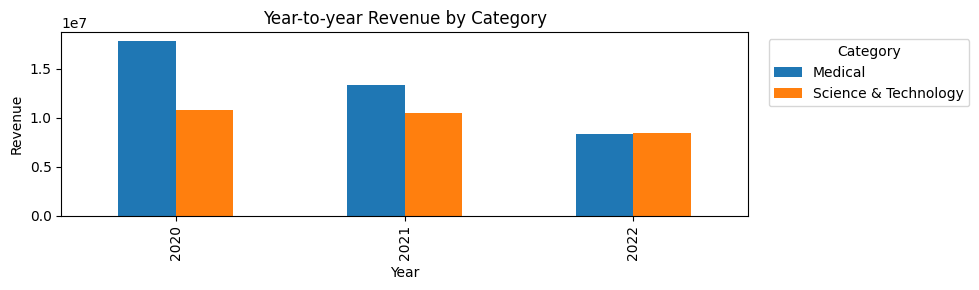

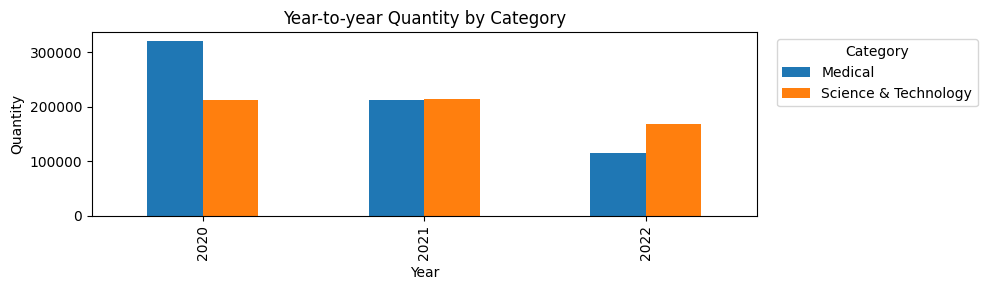

In [136]:
tmp = df.copy()
tmp["year"] = tmp["date"].dt.year

yearly = (
    tmp.groupby(["year", "category"], as_index=False)[["revenue", "qty"]]
      .sum()
)

rev_pivot = yearly.pivot(index="year", columns="category", values="revenue").fillna(0)
qty_pivot = yearly.pivot(index="year", columns="category", values="qty").fillna(0)

ax = rev_pivot.plot(kind="bar", figsize=(10, 3))
ax.set_title("Year-to-year Revenue by Category")
ax.set_xlabel("Year")
ax.set_ylabel("Revenue")
ax.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

ax = qty_pivot.plot(kind="bar", figsize=(10, 3))
ax.set_title("Year-to-year Quantity by Category")
ax.set_xlabel("Year")
ax.set_ylabel("Quantity")
ax.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

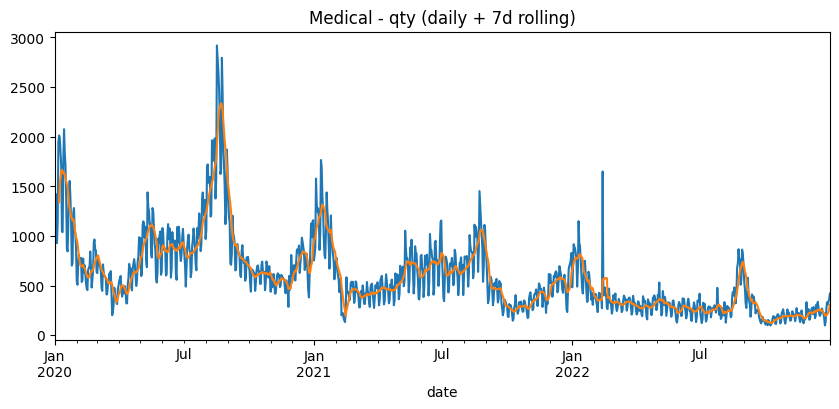

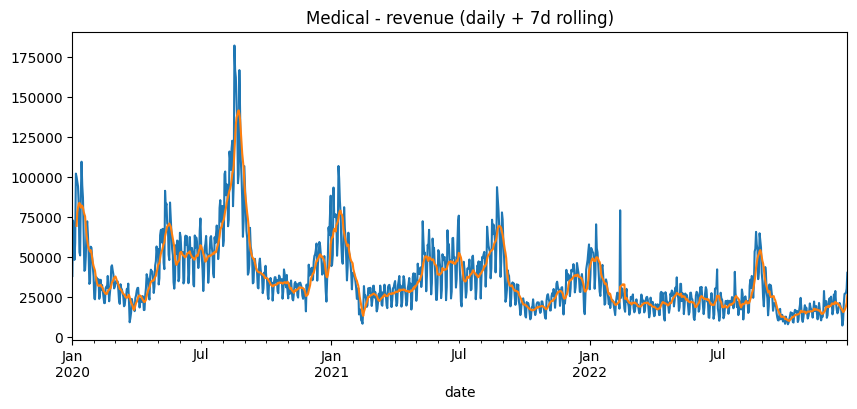

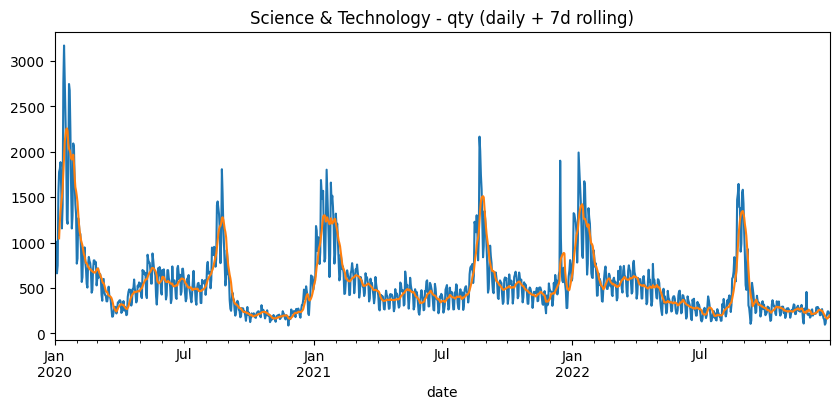

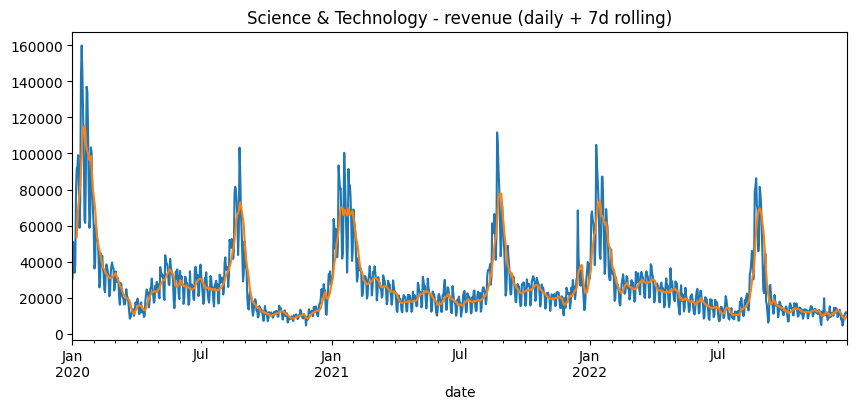

In [137]:
for cat in cats:
    for tgt in targets:
        s = (df[df["category"] == cat]
             .sort_values("date")
             .set_index("date")[tgt])

        ax = s.plot(title=f"{cat} - {tgt} (daily + 7d rolling)", figsize=(10, 4))
        s.rolling(7).mean().plot(ax=ax)
        plt.show()

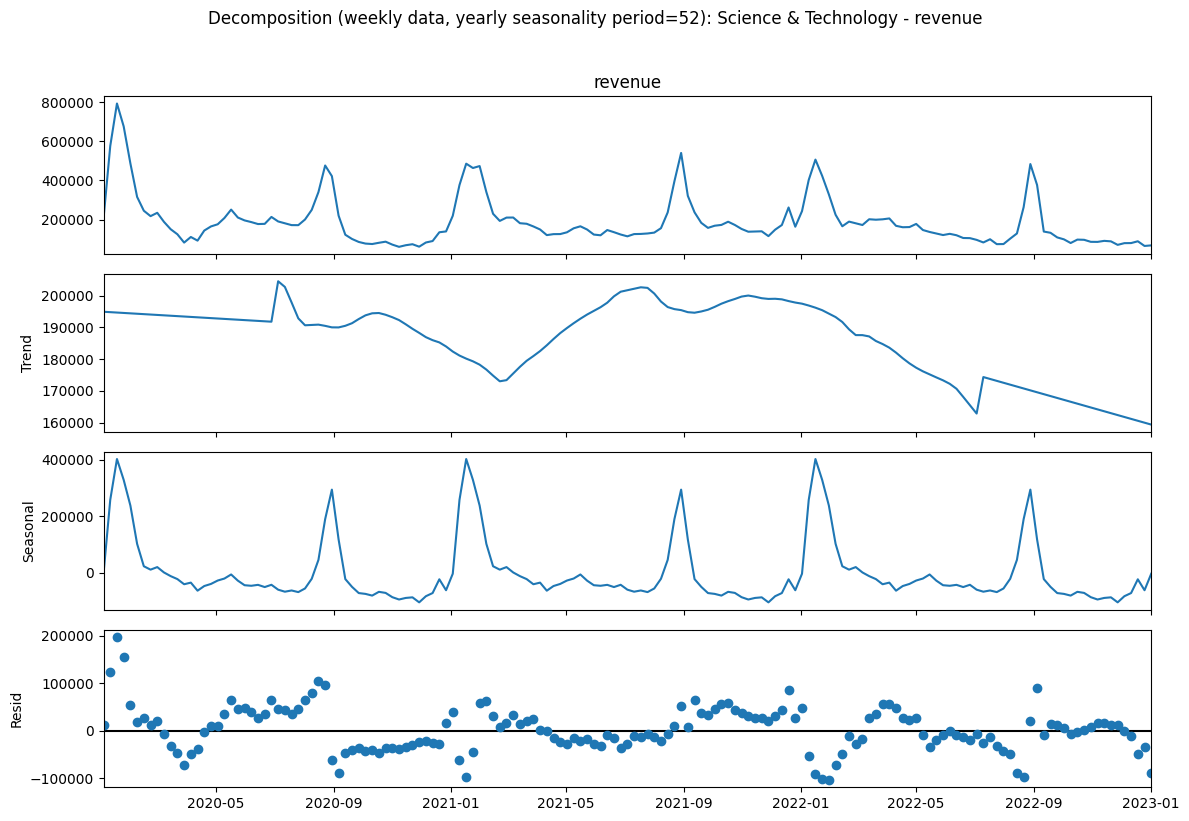

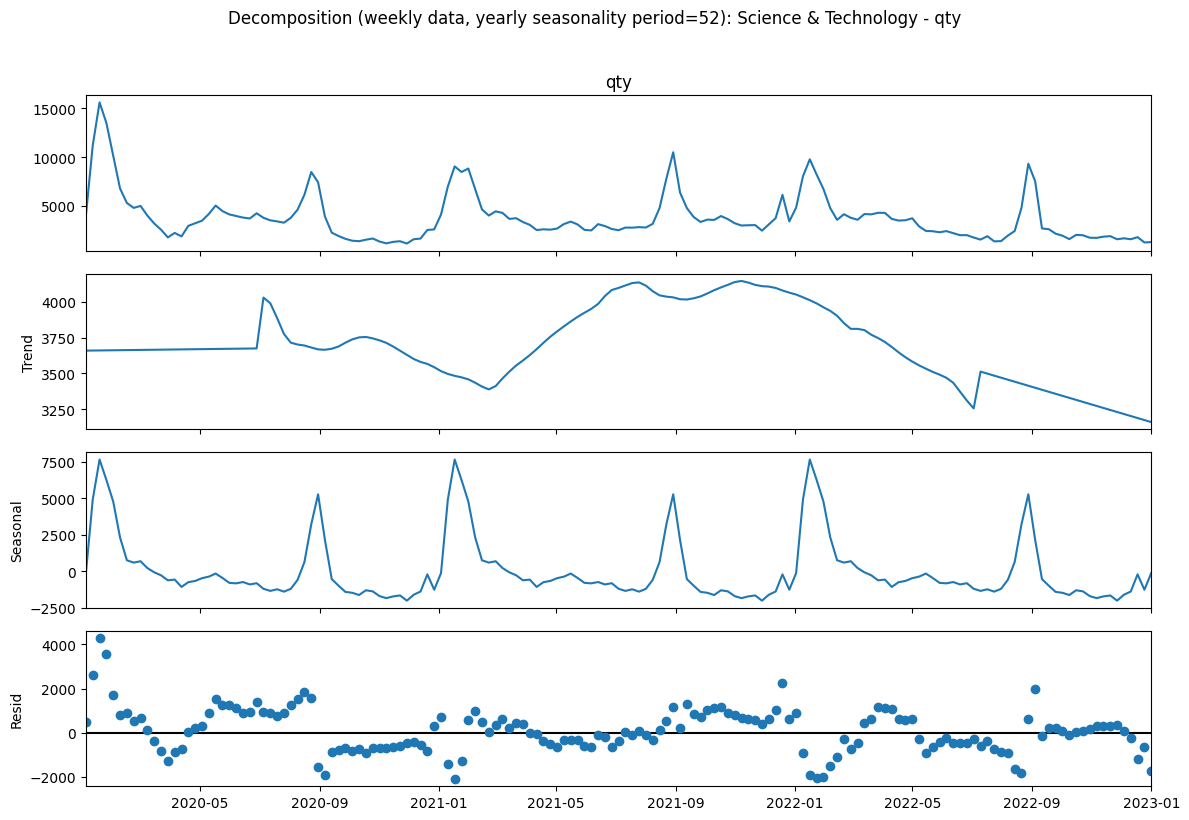

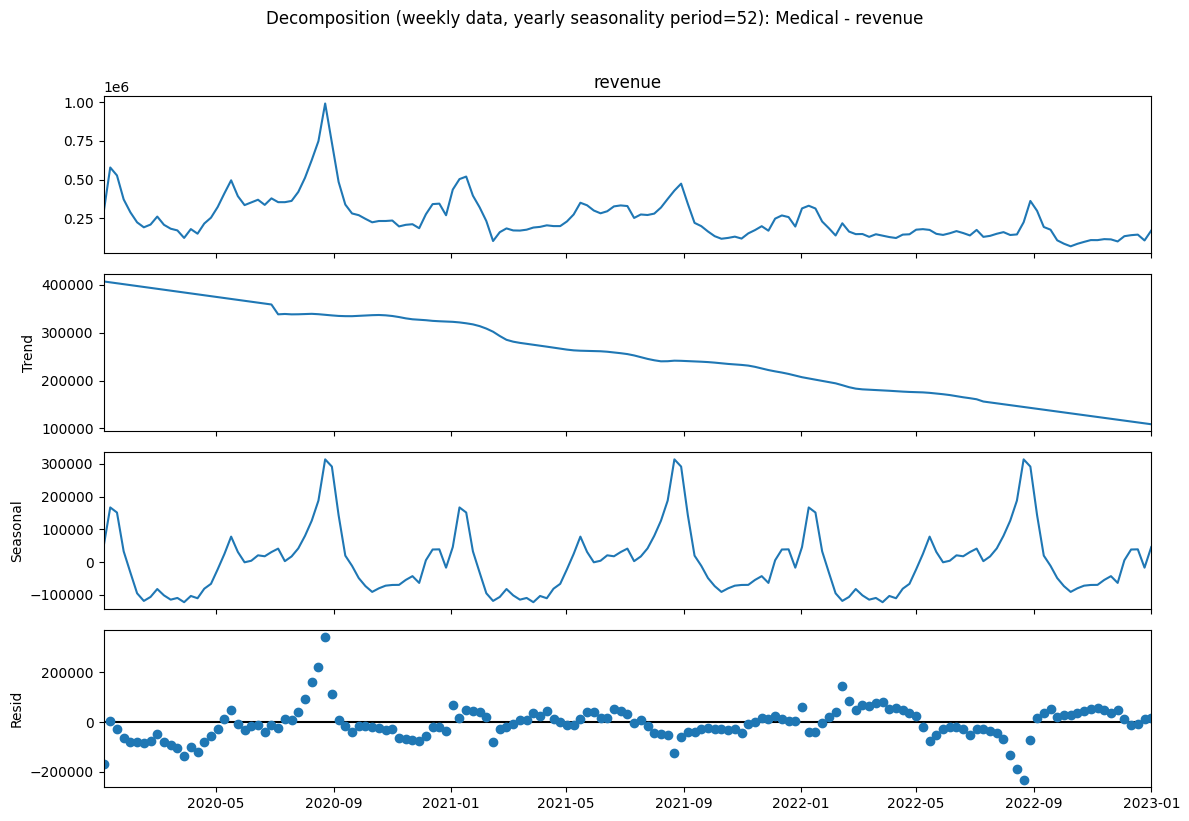

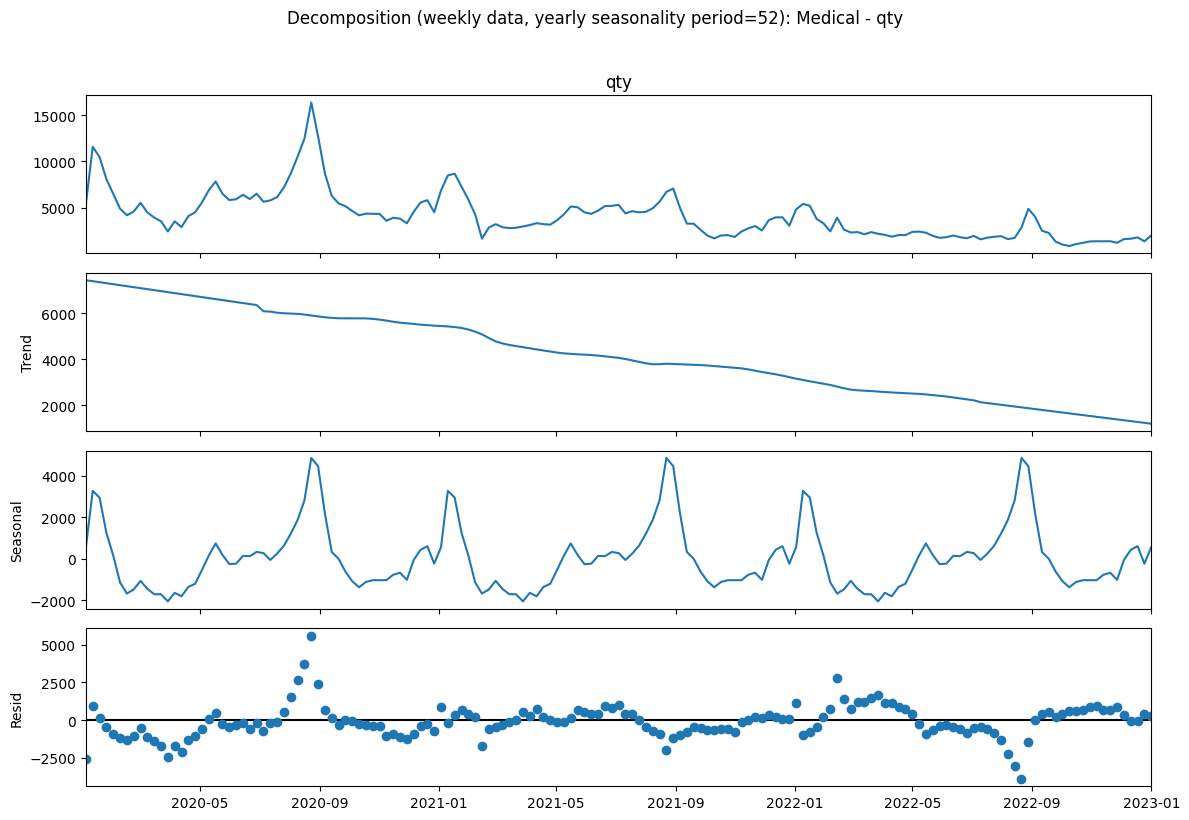

In [ ]:
week_rule = "W-SUN"
yearly_period_weeks = 52  # 1 year = 52 weeks

for cat in cats:
    for tgt in targets:
        sub = df[df["category"] == cat].copy()
        sub["date"] = pd.to_datetime(sub["date"]).dt.normalize()

        # build regularized daily series to aggregate to weekly
        s = (sub.sort_values("date")
               .set_index("date")[tgt]
               .asfreq("D")
               .fillna(0.0))  # alternatively interpolate("time") if skipped dates = missing data

        s_w = s.resample(week_rule).sum()

        # checker since seasonal_decompose needs at least 2 periods worth of data
        if len(s_w.dropna()) < 2 * yearly_period_weeks:
            print(f"[SKIP] {cat}/{tgt}: not enough weekly points for period={yearly_period_weeks} (n={len(s_w)})")
            continue

        try:
            dec = seasonal_decompose(
                s_w,
                model="additive",
                period=yearly_period_weeks,
                extrapolate_trend="freq"
            )
            fig = dec.plot()
            fig.set_size_inches(12, 8)
            fig.suptitle(f"Decomposition (weekly data, yearly seasonality period={yearly_period_weeks}): {cat} - {tgt}", y=1.02)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"[WARN] decomposition failed for {cat}/{tgt}: {e}")

Medical


,date,qty,revenue,is_holiday
11,2020-01-06,1942,101949.71,0
13,2020-01-07,2013,99794.75,0
15,2020-01-08,1988,96937.62,0
27,2020-01-14,2076,109387.34,0
445,2020-08-10,1964,115766.47,0
451,2020-08-13,1946,117669.87,0
453,2020-08-14,1983,122517.41,0
459,2020-08-17,2919,182034.11,0
461,2020-08-18,2789,166605.40,0
463,2020-08-19,2659,162127.52,0


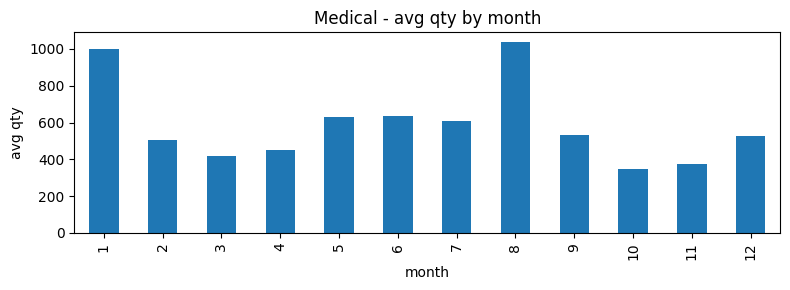

Science & Technology


,date,qty,revenue,is_holiday
16,2020-01-09,1886,99094.70,0
24,2020-01-13,2754,142496.06,0
26,2020-01-14,3171,159839.59,0
28,2020-01-15,2796,144770.58,0
30,2020-01-16,2426,122704.84,0
32,2020-01-17,2000,100040.85,0
40,2020-01-21,2747,136988.13,0
42,2020-01-22,2677,134354.87,0
44,2020-01-23,2217,112407.82,0
52,2020-01-27,2092,103399.85,0


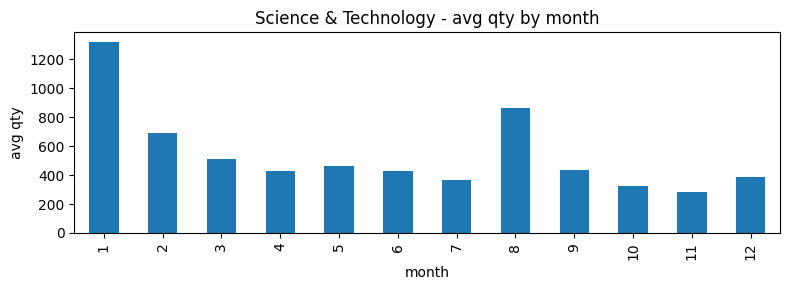

In [138]:
for cat in cats:
    print(cat)

    sub = df[df["category"] == cat].copy()

    # top 15 spike days
    top = (sub.sort_values("qty", ascending=False)
             .head(15)[["date", "qty", "revenue", "is_holiday"]]
             .sort_values("date"))
    display(top)

    sub["month"] = sub["date"].dt.month
    monthly = sub.groupby("month")["qty"].mean()

    plt.figure(figsize=(8, 3))
    monthly.plot(kind="bar", title=f"{cat} - avg qty by month")
    plt.xlabel("month")
    plt.ylabel("avg qty")
    plt.tight_layout()
    plt.show()

In [ ]:
rows = []

for cat in cats:
    d0 = df[df["category"] == cat].copy()
    d0["date"] = pd.to_datetime(d0["date"]).dt.normalize()

    d0["month"] = d0["date"].dt.month.astype(int)
    d0["dow"]   = d0["date"].dt.dayofweek.astype(int)
    d0["year"]  = d0["date"].dt.year.astype(int)

    d0["is_jan"] = (d0["month"] == 1).astype(int)
    d0["is_aug"] = (d0["month"] == 8).astype(int)

    # categorical fixed effects
    d0["dow"]  = pd.Categorical(d0["dow"], categories=list(range(0, 7)))
    d0["year"] = pd.Categorical(d0["year"])

    for tgt in targets:
        d = d0.copy()
        d["y"] = np.log1p(d[tgt])

        model = smf.ols(
            "y ~ is_jan + is_aug + C(dow) + C(year) + is_holiday",
            data=d
        ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

        jan_coef = model.params.get("is_jan", np.nan)
        aug_coef = model.params.get("is_aug", np.nan)

        rows.append({
            "category": cat,
            "target": tgt,  # <-- fix here
            "jan_lift_%": np.expm1(jan_coef) * 100,
            "p_jan": model.pvalues.get("is_jan", np.nan),
            "aug_lift_%": np.expm1(aug_coef) * 100,
            "p_aug": model.pvalues.get("is_aug", np.nan),
            "n_obs": int(model.nobs),
        })

results_df = pd.DataFrame(rows)

results_df["jan_lift_%"] = results_df["jan_lift_%"].round(1)
results_df["aug_lift_%"] = results_df["aug_lift_%"].round(1)
results_df["p_jan"] = results_df["p_jan"].map(lambda x: f"{x:.3g}")
results_df["p_aug"] = results_df["p_aug"].map(lambda x: f"{x:.3g}")

results_df.sort_values(["category", "target"])

,category,target,jan_lift_%,p_jan,aug_lift_%,p_aug,n_obs
3,Medical,qty,113.4,9e-30,87.6,1.23e-09,1096
2,Medical,revenue,82.7,3.63e-17,99.2,3.05e-12,1096
1,Science & Technology,qty,222.0,5.21e-42,92.1,1.08e-06,1096
0,Science & Technology,revenue,237.2,4.19e-55,105.7,1.41e-07,1096


In [20]:
months_focus = [1, 8]  # Jan, Aug

df2 = df.copy()
df2["date"] = pd.to_datetime(df2["date"]).dt.normalize()
df2["month"] = df2["date"].dt.month.astype(int)
df2["dow"]   = df2["date"].dt.dayofweek.astype(int)  # 0=Mon ... 6=Sun
df2["year"]  = df2["date"].dt.year.astype(int)

# week in month 1..5 (some months have partial 5th week)
df2["week_in_month"] = ((df2["date"].dt.day - 1) // 7 + 1).astype(int)

In [21]:
rows = []

for cat in cats:
    for m in months_focus:
        sub = df2[(df2["category"] == cat) & (df2["month"] == m)].copy()

        for tgt in targets:
            wk_means  = sub.groupby("week_in_month")[tgt].mean()
            dow_means = sub.groupby("dow")[tgt].mean()

            rows.append({
                "category": cat, "month": m, "target": tgt,
                "top_week": int(wk_means.idxmax()),
                "top_week_mean": float(wk_means.max()),
                "top_dow": int(dow_means.idxmax()),
                "top_dow_mean": float(dow_means.max()),
            })

peaks = pd.DataFrame(rows)
peaks

,category,month,target,top_week,top_week_mean,top_dow,top_dow_mean
0,Science & Technology,1,revenue,2,81332.352857,1,93694.060000
1,Science & Technology,1,qty,2,1554.952381,1,1812.750000
2,Science & Technology,8,revenue,4,70921.700952,0,56851.944667
3,Science & Technology,8,qty,4,1330.571429,0,1066.733333
4,Medical,1,revenue,2,69256.317143,1,68825.565000
5,Medical,1,qty,2,1244.428571,1,1285.666667
6,Medical,8,revenue,4,78348.902857,0,82111.531333
7,Medical,8,qty,4,1226.809524,0,1281.000000


In [22]:
for cat in cats:
    for tgt in targets:
        print(f"{cat} - {tgt}")
        sub = df[df["category"]==cat].sort_values("date").set_index("date")[tgt]
        print("lag1 corr:", sub.corr(sub.shift(1)))
        print("lag7 corr:", sub.corr(sub.shift(7)))
        print("\n")

Science & Technology - revenue
lag1 corr: 0.9023588888677421
lag7 corr: 0.8251837840714406


Science & Technology - qty
lag1 corr: 0.8967013883070131
lag7 corr: 0.8245633528643851


Medical - revenue
lag1 corr: 0.880373731181763
lag7 corr: 0.8517728844489848


Medical - qty
lag1 corr: 0.9000596182962233
lag7 corr: 0.8765974190003231




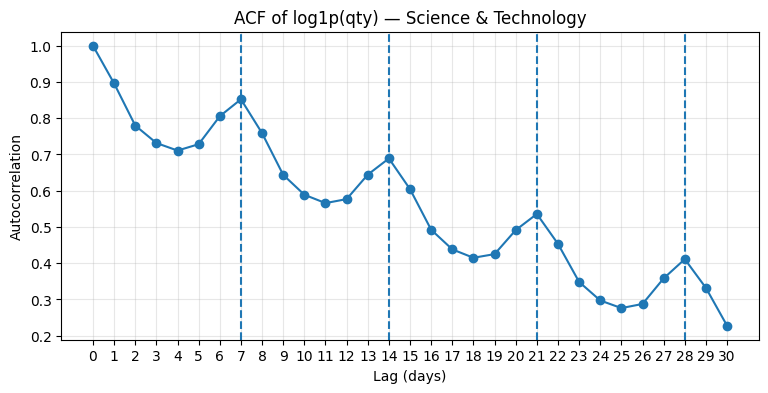

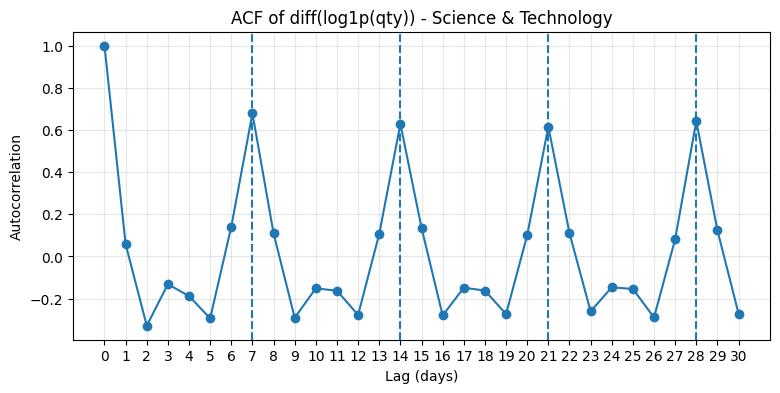

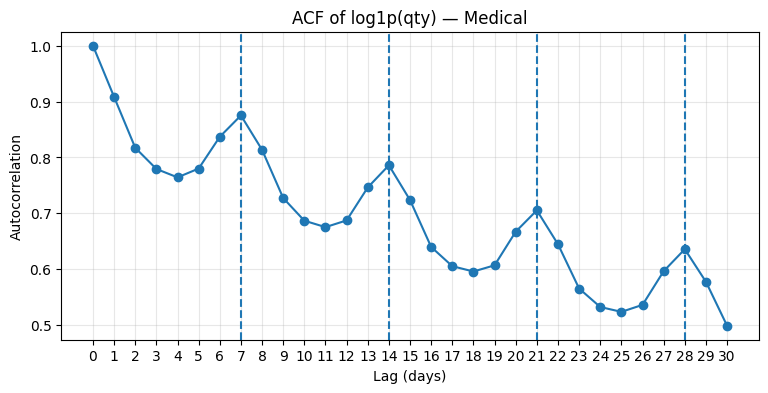

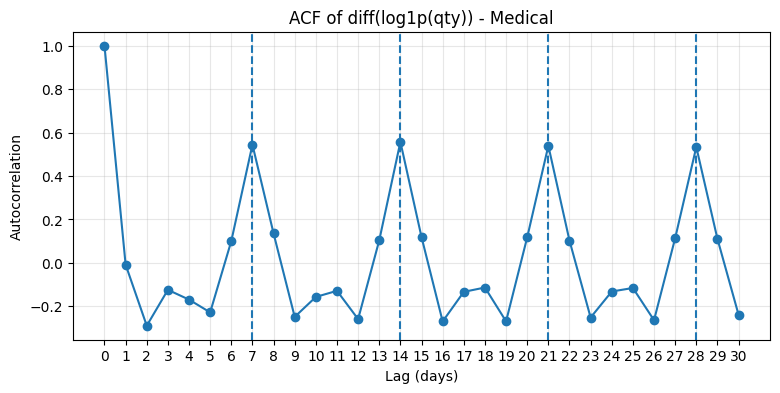

In [23]:
NLAGS = 30

for cat in cats:
    s = (df[df["category"] == cat]
         .sort_values("date")
         .set_index("date")["qty"])

    x = np.log1p(s)
    acf_vals = acf(x, nlags=NLAGS, fft=True)
    lags = np.arange(len(acf_vals))

    plt.figure(figsize=(9,4))
    plt.plot(lags, acf_vals, marker="o")
    plt.axvline(7, linestyle="--")
    plt.axvline(14, linestyle="--")
    plt.axvline(21, linestyle="--")
    plt.axvline(28, linestyle="--")
    plt.title(f"ACF of log1p(qty) — {cat}")
    plt.xlabel("Lag (days)")
    plt.ylabel("Autocorrelation")
    plt.xticks(lags)
    plt.grid(True, alpha=0.3)
    plt.show()

    # ACF on diffs (trend-reduced)
    d = x.diff().dropna()
    acf_diff = acf(d, nlags=NLAGS, fft=True)
    lags2 = np.arange(len(acf_diff))

    plt.figure(figsize=(9,4))
    plt.plot(lags2, acf_diff, marker="o")
    plt.axvline(7, linestyle="--")
    plt.axvline(14, linestyle="--")
    plt.axvline(21, linestyle="--")
    plt.axvline(28, linestyle="--")
    plt.title(f"ACF of diff(log1p(qty)) - {cat}")
    plt.xlabel("Lag (days)")
    plt.ylabel("Autocorrelation")
    plt.xticks(lags2)
    plt.grid(True, alpha=0.3)
    plt.show()

In [24]:
for cat in cats:
    sub = df[df["category"] == cat]
    print("\n", cat)
    display(sub.groupby("is_holiday", as_index=False)[["qty","revenue"]].mean().rename(index={0:"non-holiday",1:"holiday"}))


 Science & Technology


,is_holiday,qty,revenue
non-holiday,0,544.397556,27218.043722
holiday,1,480.656250,24184.460938



 Medical


,is_holiday,qty,revenue
non-holiday,0,594.340226,36272.579408
holiday,1,469.125000,28022.216563


In [25]:
maxlags = 7

rows = []

for cat in cats:
    sub0 = df[df["category"] == cat].copy()
    sub0["date"] = pd.to_datetime(sub0["date"]).dt.normalize()
    sub0["dow"] = sub0["date"].dt.dayofweek
    sub0["month"] = sub0["date"].dt.month
    sub0["t"] = (sub0["date"] - sub0["date"].min()).dt.days

    for tgt in targets:
        m = smf.ols(
            f"{tgt} ~ is_holiday + is_holiday_ytd + is_holiday_tmr + C(dow) + C(month) + t",
            data=sub0
        ).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})

        rows.append({
            "category": cat,
            "target": tgt,
            "coef_holiday": m.params.get("is_holiday", np.nan),
            "p_holiday": m.pvalues.get("is_holiday", np.nan),
            "coef_ytd": m.params.get("is_holiday_ytd", np.nan),
            "p_ytd": m.pvalues.get("is_holiday_ytd", np.nan),
            "coef_tmr": m.params.get("is_holiday_tmr", np.nan),
            "p_tmr": m.pvalues.get("is_holiday_tmr", np.nan),
            "n": int(m.nobs),
        })

results = pd.DataFrame(rows).sort_values(["category", "target"]).reset_index(drop=True)

for c in ["p_holiday", "p_ytd", "p_tmr"]:
    results[c.replace("p_", "sig_")] = results[c] < 0.05

results

,category,target,coef_holiday,p_holiday,coef_ytd,p_ytd,coef_tmr,p_tmr,n,sig_holiday,sig_ytd,sig_tmr
0,Medical,qty,-185.538279,4.741221e-08,-12.906925,0.627964,-62.280216,0.038620,1096,True,False,True
1,Medical,revenue,-11398.866209,9.775409e-09,-1262.199997,0.448626,-2938.826107,0.152958,1096,True,False,False
2,Science & Technology,qty,-163.905632,2.533041e-04,15.109785,0.773841,-48.895401,0.088398,1096,True,False,False
3,Science & Technology,revenue,-8203.720149,2.039763e-04,810.976265,0.758792,-2354.933401,0.095431,1096,True,False,False


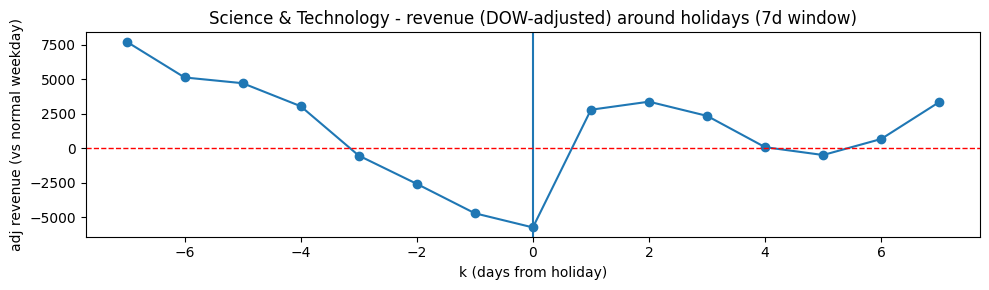

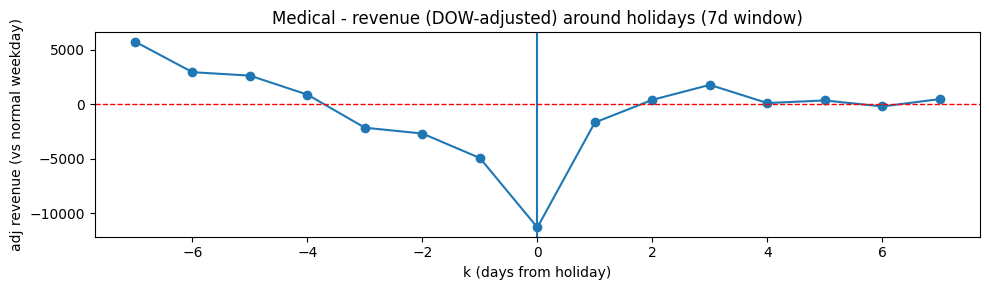

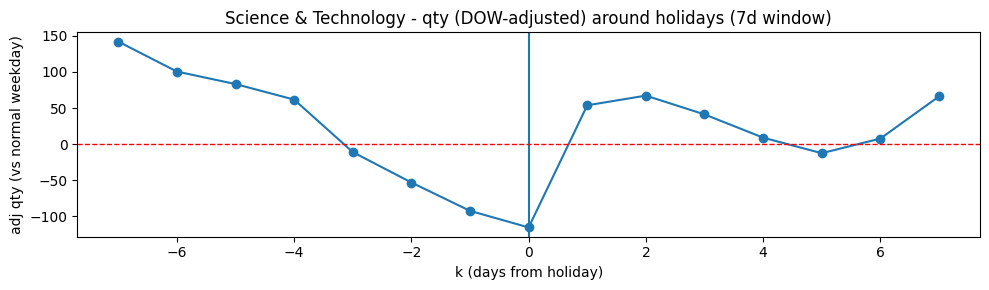

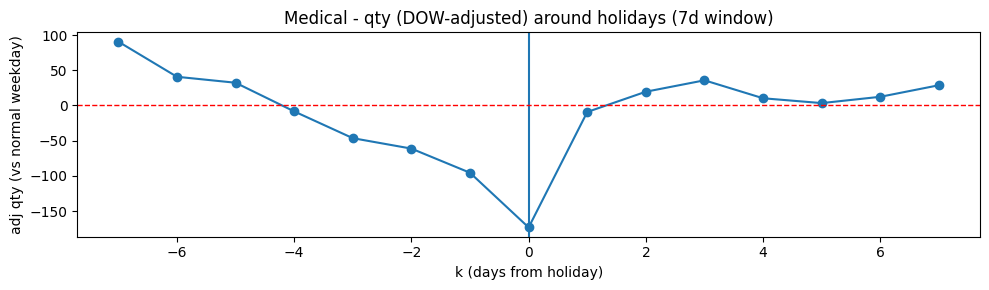

In [ ]:
window = 7

win = pd.DataFrame(
    [(hd + pd.Timedelta(days=k), k) for hd in hol_dates for k in range(-window, window + 1)],
    columns=["date", "k"]
)

# if overlaps, keep nearest holiday date (smallest abs(k))
win = (win
       .sort_values("k", key=lambda s: s.abs())
       .drop_duplicates("date"))

k_min, k_max = int(win["k"].min()), int(win["k"].max())

# plots
for tgt in targets:
    for cat in cats:
        sub = df[df["category"] == cat].copy()
        sub["date"] = pd.to_datetime(sub["date"]).dt.normalize()

        # adjust by day-of-week
        sub["dow"] = sub["date"].dt.dayofweek
        dow_mean = sub.groupby("dow")[tgt].mean()
        sub["adj"] = sub[tgt] - sub["dow"].map(dow_mean)

        tmp = sub.merge(win, on="date", how="inner")

        prof = (tmp.groupby("k")["adj"].mean()
                  .reindex(range(k_min, k_max + 1)))

        prof.plot(
            marker="o",
            figsize=(10, 3),
            title=f"{cat} - {tgt} (DOW-adjusted) around holidays ({window}d window)"
        )
        plt.axvline(0)
        plt.axhline(0, color="red", linestyle="--", linewidth=1)
        plt.xlabel("k (days from holiday)")
        plt.ylabel(f"adj {tgt} (vs normal weekday)")
        plt.tight_layout()
        plt.show()


## Prophet

In [90]:
from itertools import product
from prophet import Prophet
from joblib import Parallel, delayed
from pandas.tseries.offsets import DateOffset

cats = ["Medical", "Science & Technology"]
targets = ["qty", "revenue"]

cutoff = "2022-01-01"
future_days = 365
sem_windows = [7, 14, 21, 28]

grid = {
    "seasonality_mode": ["additive", "multiplicative"],
    "changepoint_prior_scale": [0.01, 0.05, 0.1],
    "seasonality_prior_scale": [1.0, 5.0, 10.0],
    "yearly_seasonality": [True, False],
}

winsor_grid = [None, 0.99, 0.995, 0.999]  # None = no winsorization

seasonality_flags = [(False, False), (True, False), (False, True), (True, True)] # (monthly, semester)
interval_width = 0.8

In [91]:
def wape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.sum(np.abs(y_true))
    return np.sum(np.abs(y_true - y_pred)) / denom if denom != 0 else np.nan

def mae(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
def prep_daily_series(df, category, target):
    d = df[df["category"] == category].copy()
    d["ds"] = pd.to_datetime(d["date"]).dt.normalize()
    d = d[["ds", target]].rename(columns={target: "y"}).sort_values("ds")

    # safeguard to make daily continuous (assume skipped dates = 0)
    full = pd.DataFrame({"ds": pd.date_range(d["ds"].min(), d["ds"].max(), freq="D")})
    d = full.merge(d, on="ds", how="left")
    d["y"] = d["y"].fillna(0.0)
    return d

def make_prophet_holidays_from_peaks(holidays_df, peaks_sub, years, sem_window_days):
    # base holidays
    base = holidays_df.rename(columns={"Date": "ds", "Holiday": "holiday"}).copy()
    base["ds"] = pd.to_datetime(base["ds"]).dt.normalize()
    base["lower_window"] = 0
    base["upper_window"] = 0

    patt = peaks_sub.copy()
    patt["month"] = patt["month"].astype(int)
    patt["top_week"] = patt["top_week"].astype(int)
    patt["top_dow"] = patt["top_dow"].astype(int)   # assumes 0..6 already

    sem_rows = []
    for y in years:
        for _, r in patt.iterrows():
            m = int(r["month"])
            wk = int(r["top_week"])
            dow = int(r["top_dow"])

            start = pd.Timestamp(year=y, month=m, day=1)
            end = start + pd.offsets.MonthEnd(0)

            cal = pd.DataFrame({"ds": pd.date_range(start, end, freq="D")})
            cal["week_in_month"] = ((cal["ds"].dt.day - 1) // 7 + 1).astype(int)
            cal["dow"] = cal["ds"].dt.dayofweek.astype(int)

            hits = cal[(cal["week_in_month"] == wk) & (cal["dow"] == dow)]
            if hits.empty:
                hits = cal[cal["dow"] == dow]  # fallback

            sem_date = hits["ds"].iloc[0]

            sem_rows.append({
                "ds": sem_date,
                "holiday": f"semester_{r['category']}_{r['target']}_m{m}",
                "lower_window": 0,
                "upper_window": int(sem_window_days),
            })

    sem = pd.DataFrame(sem_rows)
    return pd.concat([base, sem], ignore_index=True)

def weekly_from_daily(ds, y, week_rule="W-SUN"):
    ds = pd.to_datetime(ds)
    if week_rule.upper() == "W-SUN":
        wk = ds.to_period("W-SUN").end_time
    elif week_rule.upper() == "W-MON":
        wk = ds.to_period("W-MON").end_time
    else:
        # use period end_time for given rule as fallback
        wk = ds.to_period(week_rule).end_time

    s = pd.Series(y, index=wk).groupby(level=0).sum().sort_index()
    return s  # index = week timestamp, values = weekly sum

In [ ]:
n_jobs = 6 # BEFORE RUNNING: CHANGE ACCORDING TO YOUR MACHINE'S NO. OF CORES (note: mine has 6 cores)
backend = "loky"           

keys = list(grid.keys())
combos = list(product(*[grid[k] for k in keys]))
cutoff_ts = pd.Timestamp(cutoff)

tuning_rows = []
tail_rows = []

def eval_one_fit(
    cat, tgt,
    train, test,
    ds_eval, y_true, yhat_b, mask,
    truth_w, base_w, n_weeks, wk_b_wape, wk_b_mae,
    years, peaks_sub,
    winsor_q, sem_w, vals,
    use_monthly, use_semester
):
    train2 = train.copy()
    cap = None
    frac_clipped = 0.0
    if winsor_q is not None:
        cap = float(train2["y"].quantile(winsor_q))
        before = train2["y"].to_numpy(dtype=float)
        train2["y"] = np.minimum(train2["y"].astype(float), cap)
        frac_clipped = float(np.mean(before > cap))

    train_log = train2.copy()
    train_log["y"] = np.log1p(train_log["y"].astype(float))

    hol_p = make_prophet_holidays_from_peaks(holidays, peaks_sub, years, sem_window_days=sem_w)
    params = dict(zip(keys, vals))

    m = Prophet(
        holidays=hol_p,
        weekly_seasonality=True,
        yearly_seasonality=params["yearly_seasonality"],
        daily_seasonality=False,
        seasonality_mode=params["seasonality_mode"],
        changepoint_prior_scale=params["changepoint_prior_scale"],
        seasonality_prior_scale=params["seasonality_prior_scale"],
        interval_width=interval_width,
        uncertainty_samples=0,
    )

    if use_monthly:
        m.add_seasonality(name="monthly", period=30.5, fourier_order=5)
    if use_semester:
        m.add_seasonality(name="semester", period=182.5, fourier_order=6)

    m.fit(train_log)

    pred = m.predict(test[["ds"]])
    yhat = np.expm1(pred["yhat"].values)[mask]

    pred_w = weekly_from_daily(ds_eval, yhat, week_rule=week_rule).reindex(truth_w.index)
    wk_p_wape = wape(truth_w.values, pred_w.values)
    wk_p_mae  = mae(truth_w.values, pred_w.values)

    return {
        "category": cat,
        "target": tgt,
        "winsor_q": winsor_q,
        "winsor_cap": cap,
        "frac_train_clipped": frac_clipped,
        "sem_window_days": sem_w,
        "use_monthly": use_monthly,
        "use_semester": use_semester,
        **params,
        "n_test_days": int(mask.sum()),

        "prophet_WAPE_daily": wape(y_true, yhat),
        "prophet_MAE_daily": mae(y_true, yhat),
        "baseline7_WAPE_daily": wape(y_true, yhat_b),
        "baseline7_MAE_daily": mae(y_true, yhat_b),

        "n_test_weeks": n_weeks,
        "prophet_WAPE_weekly": wk_p_wape,
        "prophet_MAE_weekly": wk_p_mae,
        "baseline7_WAPE_weekly": wk_b_wape,
        "baseline7_MAE_weekly": wk_b_mae,
    }

for cat in cats:
    for tgt in targets:
        d = prep_daily_series(df, cat, tgt).sort_values("ds")

        train = d[d["ds"] < cutoff_ts].copy()
        test  = d[d["ds"] >= cutoff_ts].copy()

        # tail diagnostics (train only)
        ytr = train["y"].to_numpy(dtype=float)
        p95, p99, p995, p999 = np.quantile(ytr, [0.95, 0.99, 0.995, 0.999])
        tail_rows.append({
            "category": cat, "target": tgt, "n_train": len(train),
            "p95": p95, "p99": p99, "p995": p995, "p999": p999,
            "pct_gt_p99": float(np.mean(ytr > p99) * 100),
            "pct_gt_p995": float(np.mean(ytr > p995) * 100),
            "pct_gt_p999": float(np.mean(ytr > p999) * 100),
        })

        # baseline (naive t-7) on original scale
        base_pred = d.set_index("ds")["y"].shift(7).reindex(test["ds"]).values
        mask = ~np.isnan(base_pred)

        ds_eval = test["ds"].values[mask]
        y_true  = test["y"].values[mask]
        yhat_b  = base_pred[mask]

        # weekly truth + baseline once
        truth_w = weekly_from_daily(ds_eval, y_true, week_rule=week_rule)
        base_w  = weekly_from_daily(ds_eval, yhat_b, week_rule=week_rule).reindex(truth_w.index)

        n_weeks = int(len(truth_w))
        wk_b_wape = wape(truth_w.values, base_w.values)
        wk_b_mae  = mae(truth_w.values, base_w.values)

        years = sorted(d["ds"].dt.year.unique())
        peaks_sub = peaks[(peaks["category"] == cat) & (peaks["target"] == tgt)].copy()

        # task builder
        tasks = []
        for winsor_q in winsor_grid:
            for sem_w in sem_windows:
                for vals in combos:
                    for use_monthly, use_semester in seasonality_flags:
                        tasks.append((winsor_q, sem_w, vals, use_monthly, use_semester))

        rows = Parallel(n_jobs=n_jobs, backend=backend, verbose=10)(
        delayed(eval_one_fit)(
            cat, tgt,
            train, test,
            ds_eval, y_true, yhat_b, mask,
            truth_w, base_w, n_weeks, wk_b_wape, wk_b_mae,
            years, peaks_sub,
            winsor_q, sem_w, vals,
            use_monthly, use_semester
        )
        for (winsor_q, sem_w, vals, use_monthly, use_semester) in tasks
    )

        tuning_rows.extend(rows)

tail_df = pd.DataFrame(tail_rows).sort_values(["category","target"])
display(tail_df)

tuning_df = pd.DataFrame(tuning_rows)

best_daily = (tuning_df.sort_values(["category","target","prophet_WAPE_daily"])
              .groupby(["category","target"], as_index=False)
              .head(1)
              .assign(
                  delta_WAPE_daily=lambda x: x["prophet_WAPE_daily"] - x["baseline7_WAPE_daily"],
                  prophet_wins_daily=lambda x: x["prophet_WAPE_daily"] < x["baseline7_WAPE_daily"],
              )
              .reset_index(drop=True))
display(best_daily)

best_weekly = (tuning_df.sort_values(["category","target","prophet_WAPE_weekly"])
               .groupby(["category","target"], as_index=False)
               .head(1)
               .assign(
                   delta_WAPE_weekly=lambda x: x["prophet_WAPE_weekly"] - x["baseline7_WAPE_weekly"],
                   prophet_wins_weekly=lambda x: x["prophet_WAPE_weekly"] < x["baseline7_WAPE_weekly"],
               )
               .reset_index(drop=True))
display(best_weekly[[
    "category","target","winsor_q","frac_train_clipped",
    "prophet_WAPE_weekly","prophet_MAE_weekly",
    "baseline7_WAPE_weekly","baseline7_MAE_weekly",
    "delta_WAPE_weekly","prophet_wins_weekly"
]])

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    3.3s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:    3.9s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:    4.3s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:    4.8s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    5.5s
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:    6.4s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    7.1s
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:    7.8s
[Parallel(

,category,target,n_train,p95,p99,p995,p999,pct_gt_p99,pct_gt_p995,pct_gt_p999
0,Medical,qty,731,1511.5,2057.100,2548.500,2828.4800,1.094391,0.547196,0.136799
1,Medical,revenue,731,87485.3,121063.148,153469.533,170815.3094,1.094391,0.547196,0.136799
2,Science & Technology,qty,731,1413.5,2144.500,2701.500,2897.2500,1.094391,0.547196,0.136799
3,Science & Technology,revenue,731,74855.0,109459.138,135276.511,148839.2127,1.094391,0.547196,0.136799


,category,target,winsor_q,winsor_cap,frac_train_clipped,sem_window_days,use_monthly,use_semester,seasonality_mode,changepoint_prior_scale,...,prophet_MAE_daily,baseline7_WAPE_daily,baseline7_MAE_daily,n_test_weeks,prophet_WAPE_weekly,prophet_MAE_weekly,baseline7_WAPE_weekly,baseline7_MAE_weekly,delta_WAPE_daily,prophet_wins_daily
0,Medical,qty,NaN,NaN,0.000000,28,False,True,multiplicative,0.05,...,73.346714,0.245367,77.339726,53,0.199032,432.042517,0.182228,395.566038,-0.012668,True
1,Medical,revenue,0.990,121063.148,0.010944,21,True,False,multiplicative,0.10,...,5007.865145,0.245279,5624.876438,53,0.187401,29596.611426,0.173118,27340.849811,-0.026906,True
2,Science & Technology,qty,0.999,2897.250,0.001368,28,False,True,additive,0.10,...,134.693061,0.262672,121.520548,53,0.268192,854.474065,0.213471,680.132075,0.028473,False
3,Science & Technology,revenue,0.995,135276.511,0.005472,7,False,True,additive,0.10,...,6586.320403,0.265167,6140.279945,53,0.268516,42820.892415,0.219124,34944.278868,0.019262,False


,category,target,winsor_q,frac_train_clipped,prophet_WAPE_weekly,prophet_MAE_weekly,baseline7_WAPE_weekly,baseline7_MAE_weekly,delta_WAPE_weekly,prophet_wins_weekly
0,Medical,qty,NaN,0.000000,0.198400,430.670482,0.182228,395.566038,0.016172,False
1,Medical,revenue,0.999,0.001368,0.173208,27355.027796,0.173118,27340.849811,0.000090,False
2,Science & Technology,qty,0.999,0.001368,0.268192,854.474065,0.213471,680.132075,0.054720,False
3,Science & Technology,revenue,0.999,0.001368,0.265112,42278.135416,0.219124,34944.278868,0.045988,False


In [95]:
print("Weekly WAPE (training) + Hyperparameter tuning")
best_daily[["category", "target", "prophet_WAPE_weekly", "winsor_q", "winsor_cap", "frac_train_clipped",
       "sem_window_days", "use_monthly", "use_semester", "seasonality_mode",
       "changepoint_prior_scale", "seasonality_prior_scale",
       "yearly_seasonality"]]

Weekly WAPE (training) + Hyperparameter tuning


,category,target,prophet_WAPE_weekly,winsor_q,winsor_cap,frac_train_clipped,sem_window_days,use_monthly,use_semester,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,yearly_seasonality
0,Medical,qty,0.199032,NaN,NaN,0.000000,28,False,True,multiplicative,0.05,10.0,False
1,Medical,revenue,0.187401,0.990,121063.148,0.010944,21,True,False,multiplicative,0.10,1.0,True
2,Science & Technology,qty,0.268192,0.999,2897.250,0.001368,28,False,True,additive,0.10,10.0,True
3,Science & Technology,revenue,0.268516,0.995,135276.511,0.005472,7,False,True,additive,0.10,5.0,True


In [165]:
cap_clips = {}
floor_logs = {}
cap_logs = {}

all_fc = []
models = {}

for _, row in best_daily.iterrows():
    cat = row["category"]
    tgt = row["target"]
    key = (cat, tgt)

    use_monthly  = bool(row.get("use_monthly", False))
    use_semester = bool(row.get("use_semester", False))

    d = prep_daily_series(df, cat, tgt).sort_values("ds")

    # winsorization
    d2 = d.copy()
    winsor_q = row.get("winsor_q", None)
    if pd.notna(winsor_q):
        winsor_q = float(winsor_q)
        cap_clip = float(d2["y"].quantile(winsor_q))
        d2["y"] = np.minimum(d2["y"].astype(float), cap_clip)
    else:
        winsor_q = None
        cap_clip = None

    # store winsor cap per (cat,tgt) for saving models later
    cap_clips[key] = cap_clip

    seasonality_mode = str(row.get("seasonality_mode", "additive")).lower()
    use_logistic = (seasonality_mode == "additive")

    d_log = d2[["ds", "y"]].copy()
    d_log["y"] = np.log1p(d_log["y"].astype(float))

    # set defaults so keys always exist
    floor_logs[key] = None
    cap_logs[key] = None

    if use_logistic:
        LOGISTIC_FLOOR_Y = 0.0
        LOGISTIC_CAP_Q = 0.99
        LOGISTIC_CAP_MULT = 2.0

        y_pos = d2["y"].astype(float)

        floor_y = float(LOGISTIC_FLOOR_Y)
        cap_y = float(y_pos.quantile(LOGISTIC_CAP_Q)) * float(LOGISTIC_CAP_MULT)
        cap_y = max(cap_y, floor_y + 1e-9)

        floor_log = float(np.log1p(floor_y))
        cap_log   = float(np.log1p(cap_y))

        d_log["floor"] = floor_log
        d_log["cap"]   = cap_log

        # store logistic bounds per (cat,tgt) for saving models later
        floor_logs[key] = floor_log
        cap_logs[key] = cap_log

    # holidays (optional: extend years for future coverage)
    years = sorted(d_log["ds"].dt.year.unique())
    peaks_sub = peaks[(peaks["category"] == cat) & (peaks["target"] == tgt)].copy()
    hol_p = make_prophet_holidays_from_peaks(
        holidays, peaks_sub, years,
        sem_window_days=int(row["sem_window_days"])
    )

    m = Prophet(
        growth="logistic" if use_logistic else "linear",
        holidays=hol_p,
        weekly_seasonality=True,
        yearly_seasonality=bool(row["yearly_seasonality"]),
        daily_seasonality=False,
        seasonality_mode=row["seasonality_mode"],
        changepoint_prior_scale=float(row["changepoint_prior_scale"]),
        seasonality_prior_scale=float(row["seasonality_prior_scale"]),
        interval_width=interval_width,
        uncertainty_samples=50,
    )

    if use_monthly:
        m.add_seasonality(name="monthly", period=30.5, fourier_order=5)
    if use_semester:
        m.add_seasonality(name="semester", period=182.5, fourier_order=6)

    fit_cols = ["ds", "y", "floor", "cap"] if use_logistic else ["ds", "y"]
    m.fit(d_log[fit_cols])

    models[key] = m

    # future
    last_ds = d_log["ds"].max()
    end_ds  = last_ds + DateOffset(years=3)
    periods = (end_ds.normalize() - last_ds.normalize()).days

    future = m.make_future_dataframe(periods=periods, freq="D", include_history=True)
    if use_logistic:
        future["floor"] = floor_log
        future["cap"]   = cap_log

    fc = m.predict(future)

    # back-transform (nonnegative)
    for c in ["yhat", "yhat_lower", "yhat_upper"]:
        if c in fc.columns:
            fc[c] = np.expm1(fc[c].astype(float)).clip(lower=0.0)

    fc["category"] = cat
    fc["target"] = tgt
    fc["use_monthly"] = use_monthly
    fc["use_semester"] = use_semester
    fc["use_logistic"] = use_logistic
    fc["winsor_q"] = winsor_q
    fc["cap_clip"] = cap_clip

    models[(cat, tgt)] = m
    all_fc.append(fc[[
        "ds","category","target",
        "use_monthly","use_semester",
        "use_logistic",
        "winsor_q","cap_clip",
        "yhat","yhat_lower","yhat_upper"
    ]])

forecast_df = (pd.concat(all_fc, ignore_index=True)
               .sort_values(["category", "target", "ds"])
               .reset_index(drop=True))

display(forecast_df)

10:49:16 - cmdstanpy - INFO - Chain [1] start processing
10:49:16 - cmdstanpy - INFO - Chain [1] done processing
10:49:16 - cmdstanpy - INFO - Chain [1] start processing
10:49:16 - cmdstanpy - INFO - Chain [1] done processing
10:49:17 - cmdstanpy - INFO - Chain [1] start processing
10:49:17 - cmdstanpy - INFO - Chain [1] done processing
10:49:17 - cmdstanpy - INFO - Chain [1] start processing
10:49:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\aimaul\AppData\Local\Temp\ipykernel_10768\2821364906.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecast_df = (pd.concat(all_fc, ignore_index=True)


,ds,category,target,use_monthly,use_semester,use_logistic,winsor_q,cap_clip,yhat,yhat_lower,yhat_upper
0,2020-01-01,Medical,qty,False,True,False,NaN,NaN,963.971558,698.780670,1199.241938
1,2020-01-02,Medical,qty,False,True,False,NaN,NaN,1059.024181,788.681764,1503.223931
2,2020-01-03,Medical,qty,False,True,False,NaN,NaN,979.441433,671.096953,1305.977927
3,2020-01-04,Medical,qty,False,True,False,NaN,NaN,694.835595,522.841600,956.679977
4,2020-01-05,Medical,qty,False,True,False,NaN,NaN,778.660716,584.184106,1169.590362
...,...,...,...,...,...,...,...,...,...,...,...
8763,2025-12-27,Science & Technology,revenue,False,True,True,0.995,117813.7555,406.936593,6.068719,22838.274147
8764,2025-12-28,Science & Technology,revenue,False,True,True,0.995,117813.7555,448.689855,6.170670,24955.472479
8765,2025-12-29,Science & Technology,revenue,False,True,True,0.995,117813.7555,753.083443,13.088843,38037.113663
8766,2025-12-30,Science & Technology,revenue,False,True,True,0.995,117813.7555,774.844733,12.641668,45022.523973


In [166]:
summary_rows = []
worst_rows = []

for cat in cats:
    for tgt in targets:
        # weekly actual
        a = (df[df["category"] == cat][["date", tgt]]
             .rename(columns={"date": "ds", tgt: "y"})
             .copy())
        a["ds"] = pd.to_datetime(a["ds"]).dt.normalize()

        a_w = (a.set_index("ds")[["y"]]
               .resample(week_rule).sum()
               .reset_index())

        # weekly predicted
        f = forecast_df[(forecast_df["category"] == cat) & (forecast_df["target"] == tgt)].copy()
        f["ds"] = pd.to_datetime(f["ds"]).dt.normalize()

        cols = ["yhat"]
        if "yhat_lower" in f.columns: cols.append("yhat_lower")
        if "yhat_upper" in f.columns: cols.append("yhat_upper")

        f_w = (f.set_index("ds")[cols]
               .resample(week_rule).sum()
               .reset_index())

        # align + holdout only
        m = a_w.merge(f_w, on="ds", how="inner")
        m = m[m["ds"] >= cutoff_ts].copy()

        # if no holdout weeks after merge, skip
        if m.empty or m["y"].abs().sum() == 0:
            summary_rows.append({
                "category": cat, "target": tgt,
                "n_weeks": int(len(m)),
                "WAPE_weekly": np.nan,
                "MAE_weekly": np.nan,
            })
            continue

        m["abs_err"] = (m["y"] - m["yhat"]).abs()
        m["ape"] = m["abs_err"] / m["y"].abs().replace(0, np.nan)

        wape_weekly = m["abs_err"].sum() / m["y"].abs().sum()
        mae_weekly = m["abs_err"].mean()

        summary_rows.append({
            "category": cat,
            "target": tgt,
            "n_weeks": int(len(m)),
            "WAPE_weekly": float(wape_weekly),
            "MAE_weekly": float(mae_weekly),
        })

        # store worst weeks (top 12 per series)
        topk = (m.sort_values("abs_err", ascending=False)
                  .head(12)[["ds", "y", "yhat", "abs_err", "ape"]]
                  .copy())
        topk.insert(0, "target", tgt)
        topk.insert(0, "category", cat)
        worst_rows.append(topk)

summary_df = (pd.DataFrame(summary_rows)
              .sort_values(["category", "target"])
              .reset_index(drop=True))

summary_df["WAPE_weekly"] = summary_df["WAPE_weekly"]
summary_df["MAE_weekly"]  = summary_df["MAE_weekly"]

print("Summary on holdout weeks")
display(summary_df)

print("Top 15 weeks with worst errors")
worst_df = (pd.concat(worst_rows, ignore_index=True)
            .sort_values(["category", "target", "abs_err"], ascending=[True, True, False])
            .reset_index(drop=True))

display(worst_df.head(40))

Summary on holdout weeks


,category,target,n_weeks,WAPE_weekly,MAE_weekly
0,Medical,qty,53,0.167918,376.167195
1,Medical,revenue,53,0.114537,18620.723197
2,Science & Technology,qty,53,0.109081,354.673560
3,Science & Technology,revenue,53,0.109660,17847.481222


Top 15 weeks with worst errors


,category,target,ds,y,yhat,abs_err,ape
0,Medical,qty,2022-01-09,5411.00,3780.399829,1630.600171,0.301349
1,Medical,qty,2022-09-04,4016.00,2692.237541,1323.762459,0.329622
2,Medical,qty,2022-08-28,4880.00,3593.019583,1286.980417,0.263725
3,Medical,qty,2022-01-02,4822.00,3546.761903,1275.238097,0.264462
4,Medical,qty,2022-02-13,3929.00,2916.347159,1012.652841,0.257738
5,Medical,qty,2022-08-21,2861.00,2113.603642,747.396358,0.261236
6,Medical,qty,2022-07-10,1588.00,2266.416748,678.416748,0.427215
7,Medical,qty,2022-09-11,2508.00,1875.600854,632.399146,0.252153
8,Medical,qty,2022-07-17,1762.00,2376.637461,614.637461,0.348829
9,Medical,qty,2022-02-20,2639.00,3197.561626,558.561626,0.211657


In [167]:
summary_rows = []

for cat in cats:
    for tgt in targets:
        # actual daily (use same prep pipeline so it's aligned with model series)
        a = prep_daily_series(df, cat, tgt).sort_values("ds").copy()
        a["ds"] = pd.to_datetime(a["ds"]).dt.normalize()

        # predicted daily from forecast_df (historical part is included because include_history=True)
        f = forecast_df[(forecast_df["category"] == cat) & (forecast_df["target"] == tgt)].copy()
        f["ds"] = pd.to_datetime(f["ds"]).dt.normalize()

        # merge on ds
        m = a.merge(f[["ds", "yhat"]], on="ds", how="inner").dropna(subset=["yhat"])

        if m.empty or m["y"].abs().sum() == 0:
            summary_rows.append({
                "category": cat, "target": tgt,
                "n_days": int(len(m)),
                "WAPE_daily_hist": np.nan,
                "n_weeks": 0,
                "WAPE_weekly_hist": np.nan,
            })
            continue

        # daily historical WAPE
        wape_daily = wape(m["y"].values, m["yhat"].values)

        # weekly historical WAPE (sum first, then WAPE)
        w = (m.set_index("ds")[["y", "yhat"]]
               .resample(week_rule).sum())
        wape_weekly = wape(w["y"].values, w["yhat"].values)

        summary_rows.append({
            "category": cat,
            "target": tgt,
            "n_days": int(len(m)),
            "WAPE_daily_hist": float(wape_daily),
            "n_weeks": int(len(w)),
            "WAPE_weekly_hist": float(wape_weekly),
        })

hist_wape_df = (pd.DataFrame(summary_rows)
                .sort_values(["category", "target"])
                .reset_index(drop=True))

print("Historical WAPE on overlapping dates (forecast_df vs actual):")
display(hist_wape_df)

Historical WAPE on overlapping dates (forecast_df vs actual):


,category,target,n_days,WAPE_daily_hist,n_weeks,WAPE_weekly_hist
0,Medical,qty,1096,0.196006,157,0.173370
1,Medical,revenue,1096,0.130364,157,0.096215
2,Science & Technology,qty,1096,0.129741,157,0.105226
3,Science & Technology,revenue,1096,0.131066,157,0.105293


In [168]:
def plot_prophet_actual_vs_forecast(
    df,
    forecast_df,
    cats,
    targets,
    plot_end="2023-08-31",
    freq=None,  # none for daily, e.g. "W-SUN" for weekly
    figsize=(20, 8),
    sharex=True,
    interval_alpha=0.2,
    legend_loc="upper center",
    show_r2=True,
    show_interval=True,
):
    plot_end = pd.Timestamp(plot_end)

    actual_long = df.copy()
    actual_long["ds"] = pd.to_datetime(actual_long["date"]).dt.normalize()
    actual_long = actual_long.melt(
        id_vars=["ds", "category"],
        value_vars=targets,
        var_name="target",
        value_name="y"
    ).dropna(subset=["y"])

    fig, axes = plt.subplots(len(cats), len(targets), figsize=figsize, sharex=sharex)
    if len(cats) == 1 and len(targets) == 1:
        axes = [[axes]]
    elif len(cats) == 1:
        axes = [axes]
    elif len(targets) == 1:
        axes = [[ax] for ax in axes]

    for i, cat in enumerate(cats):
        for j, tgt in enumerate(targets):
            ax = axes[i][j]

            a = actual_long[(actual_long["category"] == cat) & (actual_long["target"] == tgt)].sort_values("ds")
            f = forecast_df[(forecast_df["category"] == cat) & (forecast_df["target"] == tgt)].sort_values("ds")

            a = a[a["ds"] <= plot_end]
            f = f[f["ds"] <= plot_end]

            # daily vs weekly aggregation
            if freq is None:
                a_plot = a[["ds", "y"]].copy()
                f_plot = f[["ds", "yhat"] + [c for c in ["yhat_lower", "yhat_upper"] if c in f.columns]].copy()
                title = f"Prophet: {cat} - {tgt}"
                xlabel = "Date"
                lab_a, lab_f, lab_i = "Actual", "Predicted", "Interval"
            else:
                a_plot = (a.set_index("ds")[["y"]].resample(freq).sum().reset_index())
                cols = ["yhat"] + [c for c in ["yhat_lower", "yhat_upper"] if c in f.columns]
                f_plot = (f.set_index("ds")[cols].resample(freq).sum().reset_index())
                title = f"Prophet Weekly: {cat} - {tgt}"
                xlabel = "Week"
                lab_a, lab_f, lab_i = "Actual", "Predicted", "Interval"

            # compute historical R^2 on overlap only
            r2 = np.nan
            if show_r2:
                mrg = a_plot.merge(f_plot[["ds", "yhat"]], on="ds", how="inner").dropna()
                if len(mrg) >= 2:
                    y_true = mrg["y"].to_numpy(dtype=float)
                    y_pred = mrg["yhat"].to_numpy(dtype=float)
                    ss_res = np.sum((y_true - y_pred) ** 2)
                    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
                    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

                if pd.notna(r2):
                    title = f"{title} (R-squared hist={r2:.3f})"

            # plot
            ax.plot(a_plot["ds"], a_plot["y"], label=lab_a)
            ax.plot(f_plot["ds"], f_plot["yhat"], label=lab_f)

            # interval ON/OFF
            if show_interval and ("yhat_lower" in f_plot.columns) and ("yhat_upper" in f_plot.columns):
                ok = f_plot["yhat_lower"].notna() & f_plot["yhat_upper"].notna()
                if ok.any():
                    ax.fill_between(
                        f_plot.loc[ok, "ds"],
                        f_plot.loc[ok, "yhat_lower"],
                        f_plot.loc[ok, "yhat_upper"],
                        alpha=interval_alpha,
                        label=lab_i
                    )

            ax.set_title(title)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(tgt)
            ax.legend(loc=legend_loc)

    plt.tight_layout()
    plt.show()

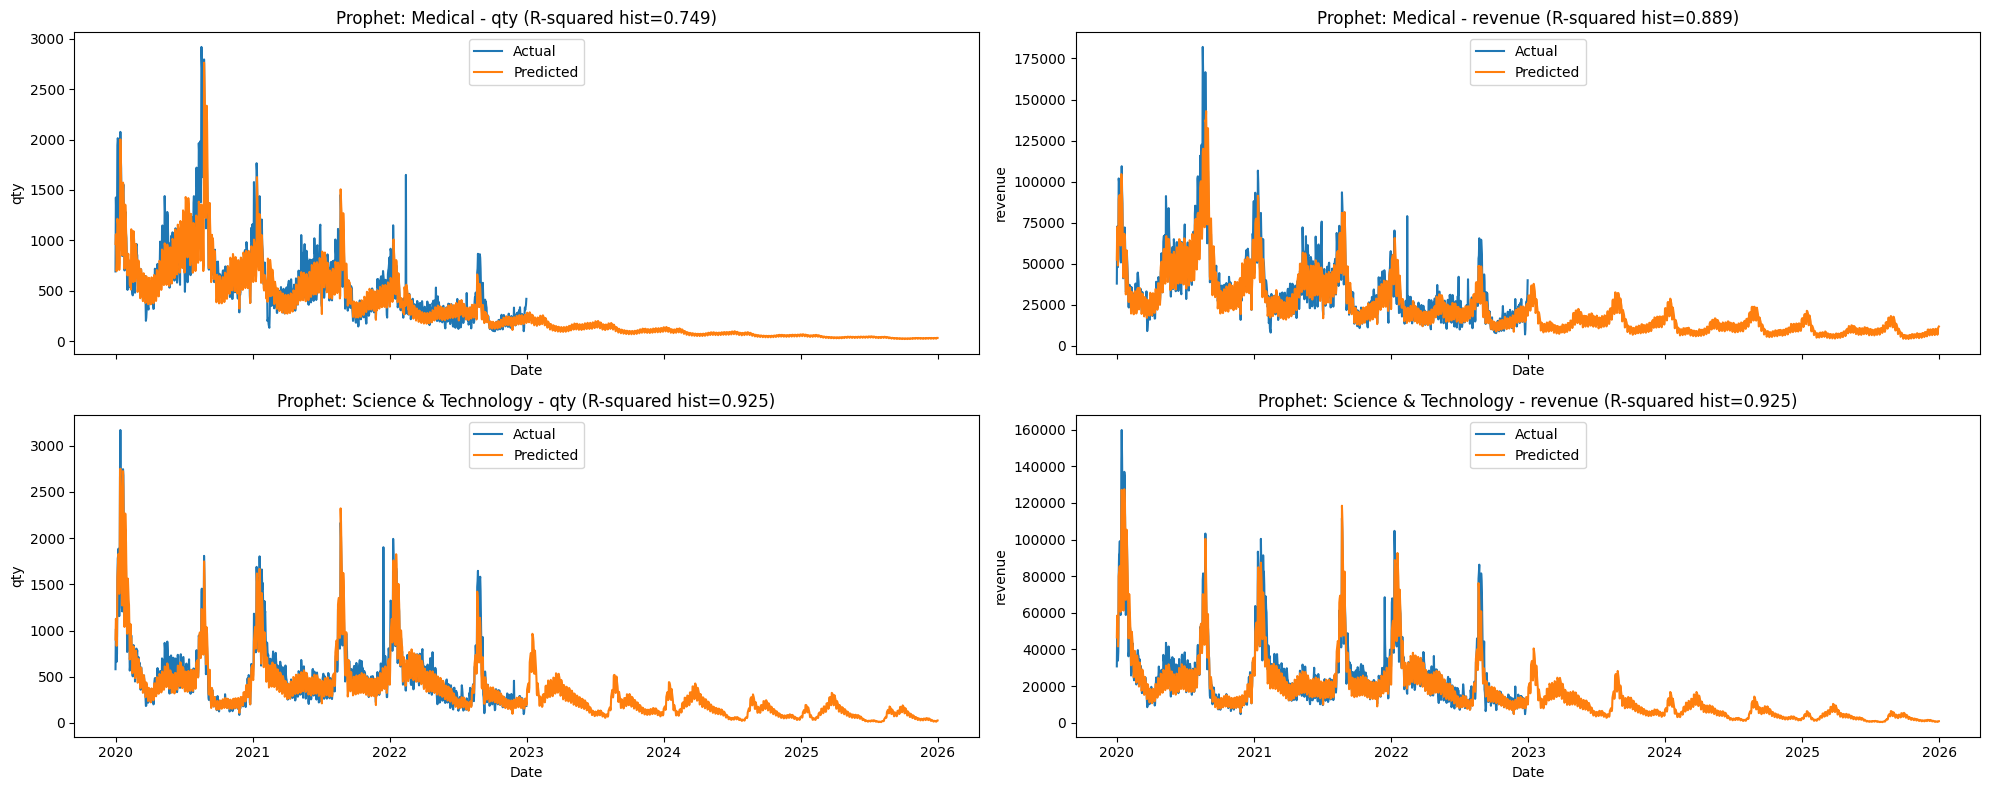

In [169]:
plot_prophet_actual_vs_forecast(df, forecast_df, cats, targets, plot_end=forecast_df["ds"].max(), freq=None, show_interval=False)

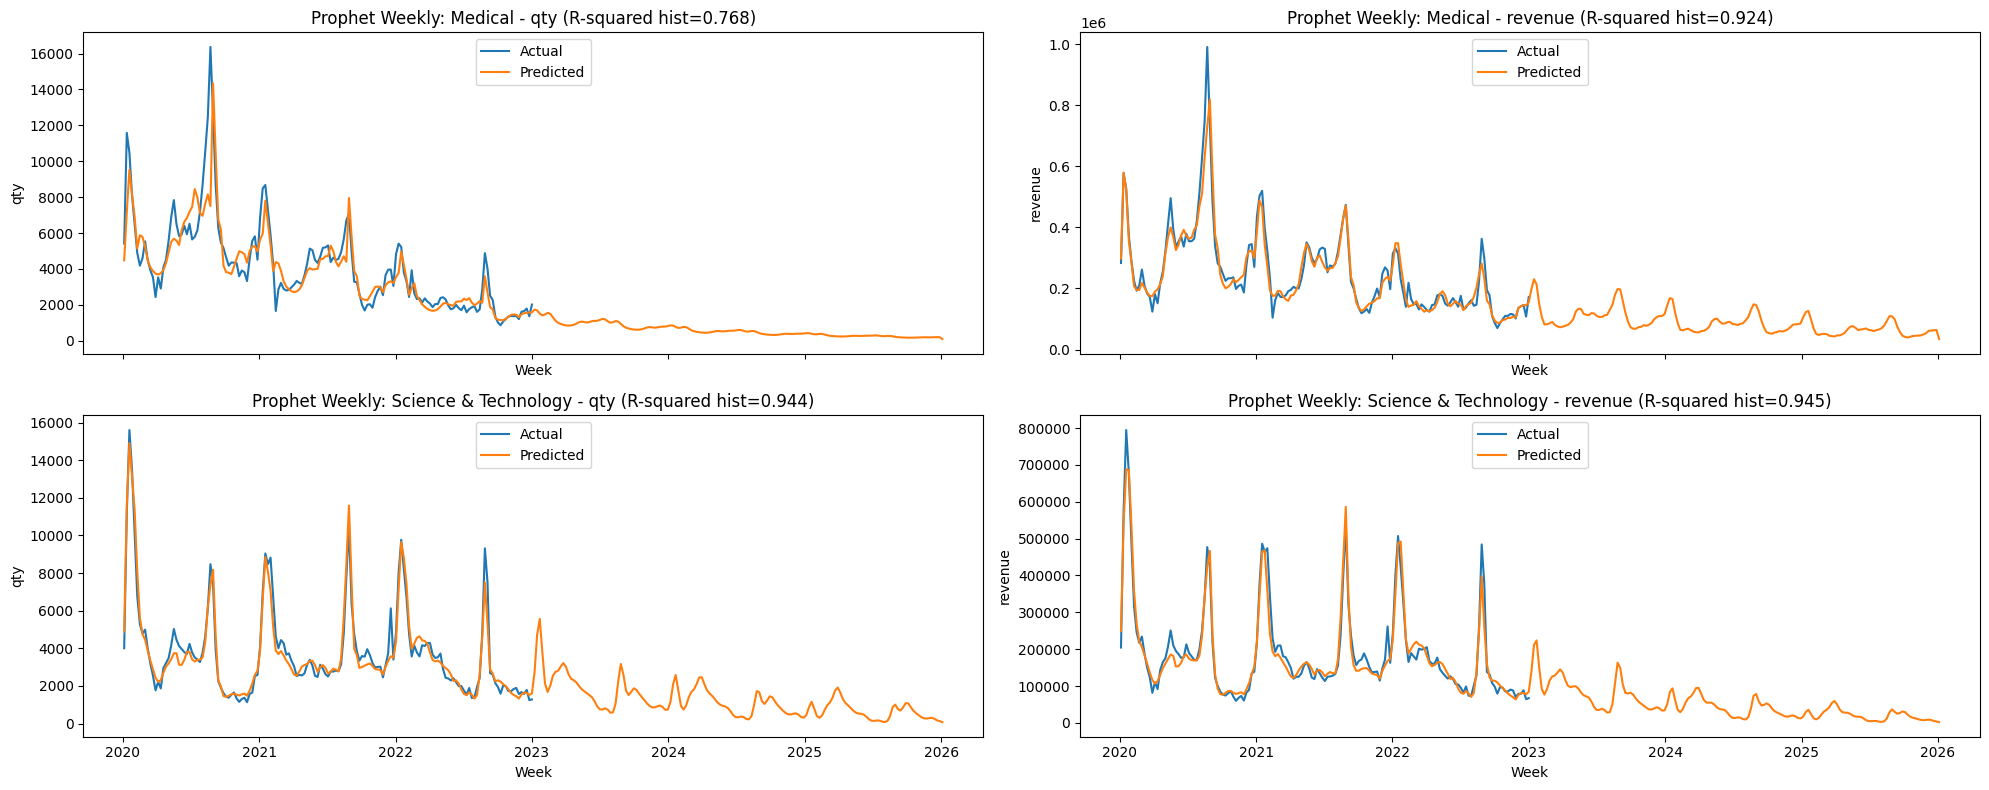

In [170]:
plot_prophet_actual_vs_forecast(df, forecast_df, cats, targets, plot_end=forecast_df["ds"].max(), freq=week_rule, show_interval=False)

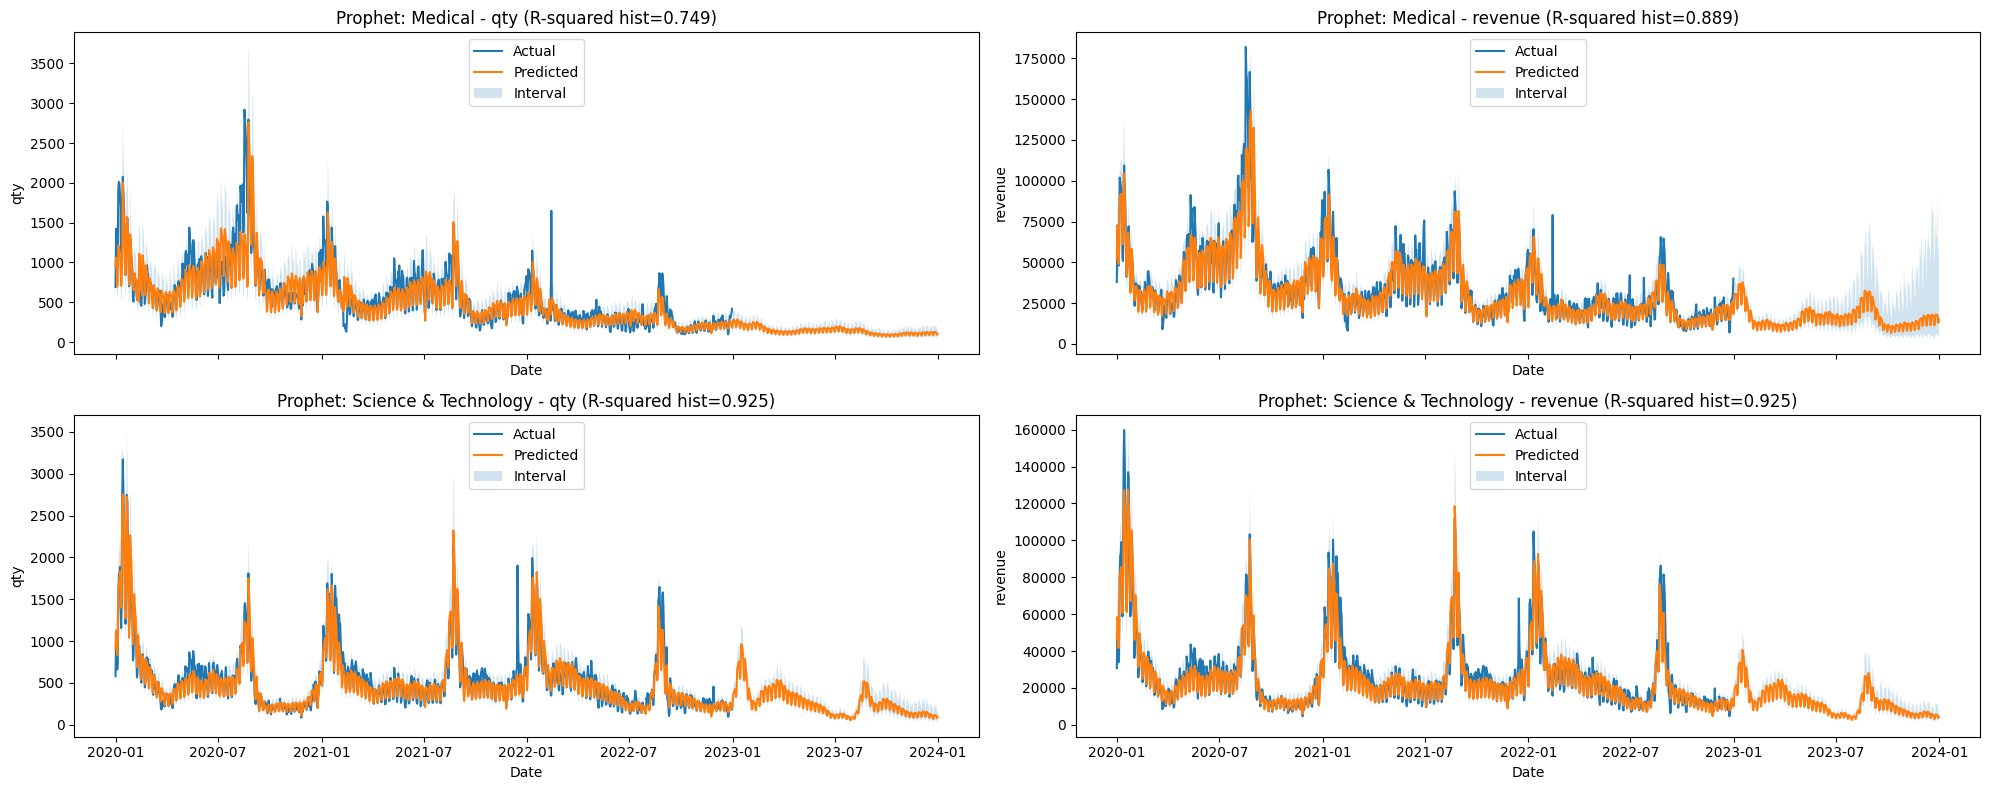

In [171]:
plot_prophet_actual_vs_forecast(df, forecast_df, cats, targets, plot_end="2023-12-31", freq=None)

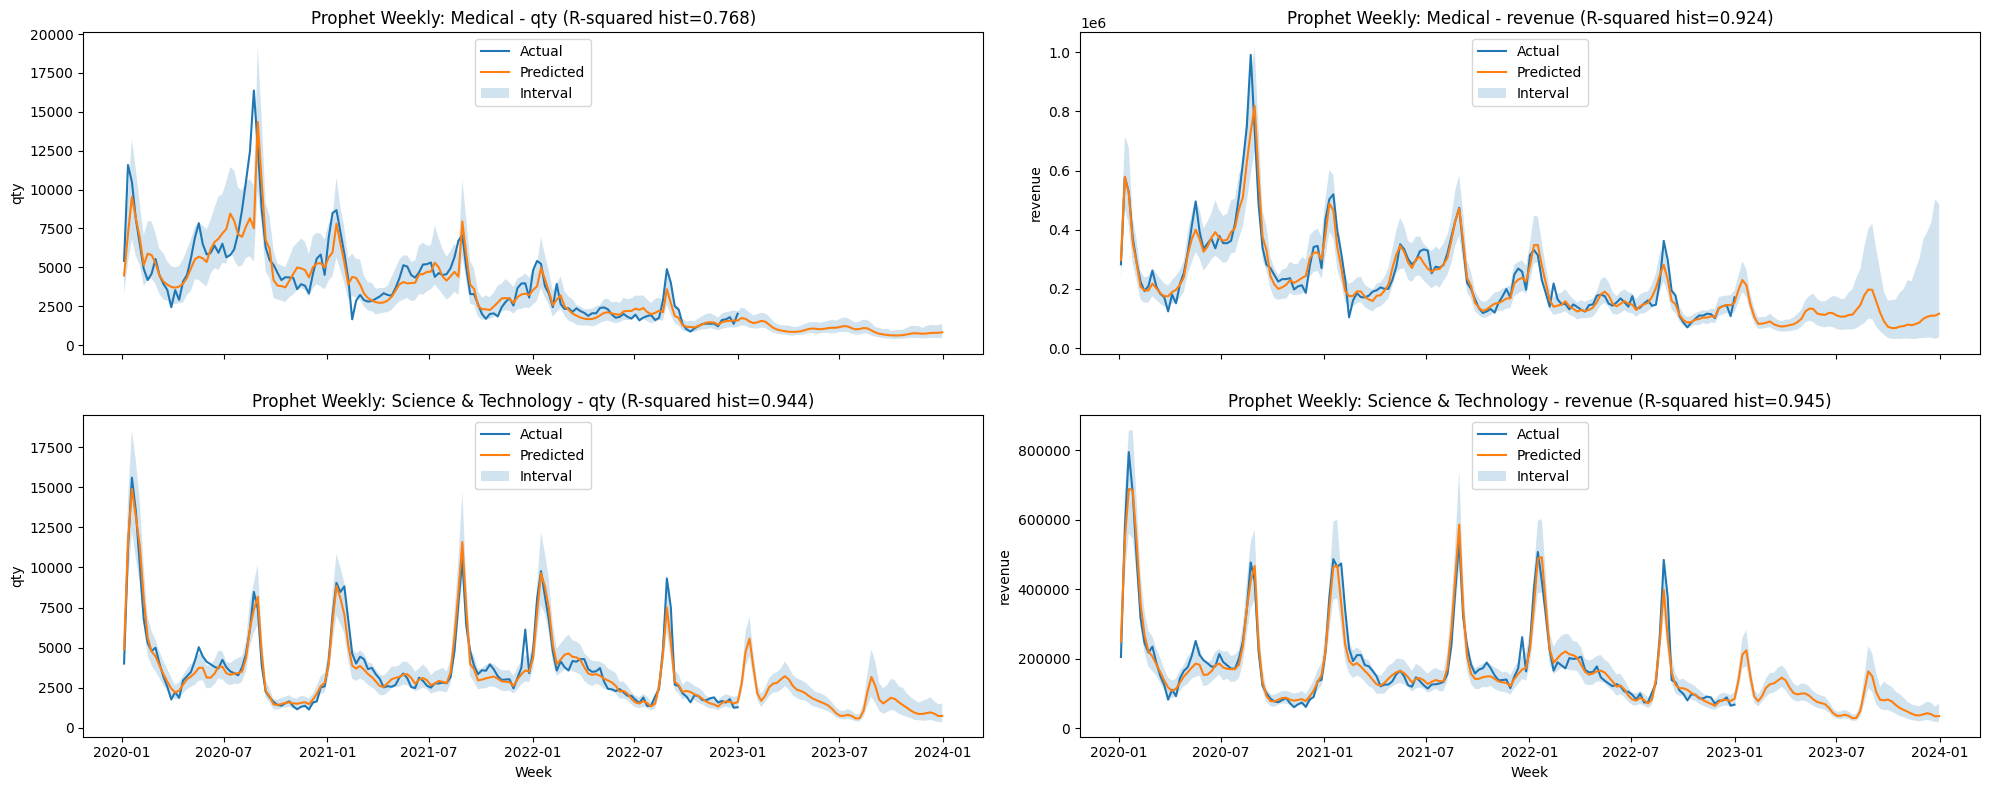

In [172]:
plot_prophet_actual_vs_forecast(df, forecast_df, cats, targets, plot_end="2023-12-31", freq=week_rule)

In [ ]:
import os
import joblib

os.makedirs("forecasting_results", exist_ok=True)

def safe_name(s: str) -> str:
    return (
        str(s).strip().lower()
        .replace("&", "and")
        .replace(" ", "_")
        .replace("__", "_")
    )

for cat in cats:
    for tgt in targets:
        fname = f"pred__{safe_name(cat)}__{safe_name(tgt)}.csv"
        save_df = forecast_df[(forecast_df["category"] == cat) & (forecast_df["target"] == tgt)].copy()
        save_df = save_df[['ds', 'category', 'target', 'yhat', 'yhat_lower', 'yhat_upper']]

        if save_df.empty:
            print(f"WARNING: empty forecast for {cat} / {tgt} (skipping)")
            continue

        save_path = os.path.join("forecasting_results", fname)
        save_df.to_csv(save_path, index=False)
        print(f"Saved -> {save_path}")

Saved -> forecasting_results\pred__medical__qty.csv
Saved -> forecasting_results\pred__medical__revenue.csv
Saved -> forecasting_results\pred__science_and_technology__qty.csv
Saved -> forecasting_results\pred__science_and_technology__revenue.csv


In [174]:
for _, row in best_daily.iterrows():
    cat = row["category"]
    tgt = row["target"]
    key = (cat, tgt)

    if key not in models:
        print(f"WARNING: missing model for {cat} / {tgt} (skipping)")
        continue

    winsor_q = row.get("winsor_q", None)
    if pd.notna(winsor_q):
        winsor_q = float(winsor_q)
    else:
        winsor_q = None

    seasonality_mode = str(row.get("seasonality_mode", "additive")).lower()
    use_logistic = (seasonality_mode == "additive")

    artifact = {
        "model": models[key],
        "meta": {
            "category": cat,
            "target": tgt,
            "trained_on": "log1p(y)",
            "needs_expm1": True,
            "use_logistic": bool(use_logistic),

            # preprocessing
            "winsor_q": winsor_q,
            "cap_clip": cap_clips.get(key, None),

            # logistic bounds (None if not logistic)
            "floor_log": floor_logs.get(key, None),
            "cap_log": cap_logs.get(key, None),

            # chosen config
            "sem_window_days": int(row["sem_window_days"]),
            "use_monthly": bool(row.get("use_monthly", False)),
            "use_semester": bool(row.get("use_semester", False)),
            "seasonality_mode": str(row.get("seasonality_mode")),
            "yearly_seasonality": bool(row.get("yearly_seasonality")),
            "changepoint_prior_scale": float(row.get("changepoint_prior_scale")),
            "seasonality_prior_scale": float(row.get("seasonality_prior_scale")),
            "interval_width": float(interval_width),

            "default_forecast_years": 3,
        },
    }

    fname = f"model__{safe_name(cat)}__{safe_name(tgt)}.joblib"
    save_path = os.path.join("models", fname)
    joblib.dump(artifact, save_path, compress=3)
    print(f"Saved -> {save_path}")

Saved -> models\model__medical__qty.joblib
Saved -> models\model__medical__revenue.joblib
Saved -> models\model__science_and_technology__qty.joblib
Saved -> models\model__science_and_technology__revenue.joblib
